In [ ]:
import os
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Funciones**

 ### **Modelos**

  Modelo nuestro

In [ ]:
def create_best_model():
    model = Sequential([

        tf.keras.layers.Rescaling(scale=1./255, input_shape=(200, 200, 3)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(name='sensitivity'),
                           tf.keras.metrics.TruePositives(name='tp'),
                           tf.keras.metrics.TrueNegatives(name='tn'),
                           tf.keras.metrics.FalsePositives(name='fp'),
                           tf.keras.metrics.FalseNegatives(name='fn')])
    return model

  MobileNetV2

In [ ]:
base_model = MobileNetV2(input_shape=(200, 200, 3), include_top=False, weights='imagenet')

def modelo_mobilenet():
    base_model.trainable = False  # Congelar el modelo base
    # preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    model = Sequential([
        # preprocess_input,
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(name='sensitivity'),
                           tf.keras.metrics.TruePositives(name='tp'),
                           tf.keras.metrics.TrueNegatives(name='tn'),
                           tf.keras.metrics.FalsePositives(name='fp'),
                           tf.keras.metrics.FalseNegatives(name='fn')])
    return model

9406464/9406464 [==============================] - 0s 0us/step


### **Graficas**

    Perdida en entrenamiento y validacion en funcion de las epocas para nuestro modelo

In [ ]:
def grafica_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 8))
    plt.plot(history.history['loss'], label=f'Perdida Entrenamiento (final: {train_loss[-1]:.2f})')
    plt.plot(history.history['val_loss'], label=f'Perdida Validacion (final: {val_loss[-1]:.2f})')
    plt.title('Perdida Entrenamiento / Validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Perdida')
    plt.legend()
    plt.grid(True)
    plt.show()

    Perdida en entrenamiento y validacion en funcion de las epocas para MobileNet

In [ ]:
def grafica_loss_mobile(history_feature_extraction, history_fine_tuning):
    train_loss = history_feature_extraction.history['loss'] + history_fine_tuning.history['loss']
    val_loss = history_feature_extraction.history['val_loss'] + history_fine_tuning.history['val_loss']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 8))
    plt.plot(epochs, train_loss, label=f'Perdida Entrenamiento (final: {train_loss[-1]:.2f})')
    plt.plot(epochs, val_loss, label=f'Perdida Validacion (final: {val_loss[-1]:.2f})')
    plt.title('Perdida Entrenamiento / Validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Perdida')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    Calcular Sensibilidad / Especificidad

In [ ]:
def calculate_sensitivity(tp, fn):
    return np.array(tp) / (np.array(tp) + np.array(fn))

In [ ]:
def calculate_specificity(tn, fp):
    return np.array(tn) / (np.array(tn) + np.array(fp))

    Matriz confusion

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]

    fig, ax = plt.subplots(figsize=(8, 6))

    # colores para las celdas
    success_color = mcolors.to_rgb('#9EE548')
    failure_color = mcolors.to_rgb("#C32240")

    # mostrar la matriz de confusion con colores
    ax.imshow([[success_color, failure_color], [failure_color, success_color]])

    labels = ['Positivo', 'Negativo']
    xaxis = np.arange(len(labels))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(labels, fontsize=13, color="#003B80")
    ax.set_yticklabels(labels, fontsize=13, color="#003B80")
    ax.text(0, 0, str(tp) + " TP", ha="center", va="center", color="#0A2102", fontsize=15)
    ax.text(0, 1, str(fp) + " FP", ha="center", va="center", color="#FAEAEA", fontsize=15)
    ax.text(1, 0, str(fn) + " FN", ha="center", va="center", color="#FAEAEA", fontsize=15)
    ax.text(1, 1, str(tn) + " TN", ha="center", va="center", color="#0A2102", fontsize=15)
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicción', fontsize=15, color="#003B80")
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Realidad', fontsize=15, color="#003B80")
    plt.tight_layout()
    plt.show()

    Sensibilidad y especificidad en entrenamiento y validacion en funcion de las epocas

In [ ]:
def plot_sensitivity_specificity(history):
    train_sensitivity = calculate_sensitivity(history.history['tp'], history.history['fn'])
    val_sensitivity = calculate_sensitivity(history.history['val_tp'], history.history['val_fn'])
    train_specificity = calculate_specificity(history.history['tn'], history.history['fp'])
    val_specificity = calculate_specificity(history.history['val_tn'], history.history['val_fp'])

    epochs = range(1, len(train_sensitivity) + 1)

    # sensibilidad
    plt.figure(figsize=(14, 8))
    plt.plot(epochs, train_sensitivity, label=f'Sensibilidad Entrenamiento (final: {train_sensitivity[-1]:.2f})')
    plt.plot(epochs, val_sensitivity, label=f'Sensibilidad Validacion (final: {val_sensitivity[-1]:.2f})')
    plt.title('Entrenamiento / Validacion de Sensibilidad')
    plt.xlabel('Epocas')
    plt.ylabel('Sensibilidad')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, len(train_sensitivity) + 1, step=1))
    plt.tight_layout()
    plt.show()

    # espeficidad
    plt.figure(figsize=(14, 8))
    plt.plot(epochs, train_specificity, label=f'Especificidad Entrenamiento (final: {train_specificity[-1]:.2f})')
    plt.plot(epochs, val_specificity, label=f'Especificidad Validacion (final: {val_specificity[-1]:.2f})')
    plt.title('Entrenamiento / Validacion de Especificidad')
    plt.xlabel('Epocas')
    plt.ylabel('Especificidad')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, len(train_specificity) + 1, step=1))
    plt.tight_layout()
    plt.show()

In [ ]:
def grafica_sensitivity_specificity(history, model, validation_dataset):
    plot_sensitivity_specificity(history)
    y_true = []
    y_pred = []

    for images, labels in validation_dataset:
        y_true.extend(labels.numpy())
        y_pred.extend((model.predict(images, verbose=False) >= 0.5).astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred).flatten()
    plot_confusion_matrix(y_true, y_pred)

    Sensibilidad y especificidad en entrenamiento y validacion en funcion de las epocas para MobileNet

In [ ]:
def plot_sensitivity_specificity_mobile(history_feature_extraction, history_fine_tuning):
    tp = history_feature_extraction.history['tp'] + history_fine_tuning.history['tp']
    fn = history_feature_extraction.history['fn'] + history_fine_tuning.history['fn']
    tn = history_feature_extraction.history['tn'] + history_fine_tuning.history['tn']
    fp = history_feature_extraction.history['fp'] + history_fine_tuning.history['fp']

    train_sensitivity = calculate_sensitivity(tp, fn)
    val_sensitivity = calculate_sensitivity(
        history_feature_extraction.history['val_tp'] + history_fine_tuning.history['val_tp'],
        history_feature_extraction.history['val_fn'] + history_fine_tuning.history['val_fn'])

    train_specificity = calculate_specificity(tn, fp)
    val_specificity = calculate_specificity(
        history_feature_extraction.history['val_tn'] + history_fine_tuning.history['val_tn'],
        history_feature_extraction.history['val_fp'] + history_fine_tuning.history['val_fp'])

    epochs = range(1, len(train_sensitivity) + 1)


    # sensibilidad
    plt.figure(figsize=(16, 8))
    plt.plot(epochs, train_sensitivity, label=f'Sensibilidad Entrenamiento (final: {train_sensitivity[-1]:.2f})')
    plt.plot(epochs, val_sensitivity, label=f'Sensibilidad Validacion (final: {val_sensitivity[-1]:.2f})')
    plt.title('Entrenamiento / Validacion de Sensibilidad')
    plt.xlabel('Epocas')
    plt.ylabel('Sensibilidad')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, len(train_sensitivity) + 1, step=1), rotation=90)

    # especificidad
    plt.figure(figsize=(16, 8))
    plt.plot(epochs, train_specificity, label=f'Especificidad Entrenamiento (final: {train_specificity[-1]:.2f})')
    plt.plot(epochs, val_specificity, label=f'Especificidad Validacion (final: {val_specificity[-1]:.2f})')
    plt.title('Entrenamiento / Validacion de Especificidad')
    plt.xlabel('Epocas')
    plt.ylabel('Especificidad')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, len(train_specificity) + 1, step=1), rotation=90) # cambiar saltos para que sean mayores?

    plt.tight_layout()
    plt.show()

In [ ]:
def grafica_sensitivity_specificity_mobile(history_feature_extraction, history_fine_tuning, model, validation_dataset):
    plot_sensitivity_specificity_mobile(history_feature_extraction, history_fine_tuning)

    # obtener predicciones y datos verdaderos
    y_true = []
    y_pred = []

    for images, labels in validation_dataset:
        y_true.extend(labels.numpy())
        y_pred.extend((model.predict(images, verbose=False) >= 0.5).astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred).flatten()

    # Graficar Matriz de Confusión
    plot_confusion_matrix(y_true, y_pred)

    Calcular mejor umbral

In [ ]:
def calculate_best_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_metric = 0
    best_sensitivity = 0
    best_specificity = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        metric = sensitivity + specificity

        if metric > best_metric:
            best_metric = metric
            best_threshold = threshold
            best_sensitivity = sensitivity
            best_specificity = specificity

    return best_threshold, best_sensitivity, best_specificity

    Graficas para Sensibilidad / Especificidad

In [ ]:
def plot_sens_spec(sensitivities, specificities, best_threshold, best_sensitivity, best_specificity):
    thresholds = np.linspace(0, 1, 100)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, sensitivities, label="Sensibilidad", color="blue")
    plt.plot(thresholds, specificities, label="Especificidad", color="orange")

    # linea para el valor umbral (la del medio)
    plt.axvline(x=best_threshold, color='red', linestyle='--')

    plt.text(best_threshold, 0.5, f'{best_threshold:.3f}', color='red', fontsize=12, ha='center')

    plt.xlabel('Umbral')
    plt.ylabel('Metricas')
    plt.title(f'Con Sensibilidad={best_sensitivity:.3f} y Especificidad={best_specificity:.3f}')
    plt.legend()
    plt.grid(True)
    plt.show()


    Generar grafica final de sensibilidad / espeficicidad

In [ ]:
def generate_sens_spec_graph(model, validation_dataset):
    y_true = []
    y_scores = []

    for images, labels in validation_dataset:
        y_true.extend(labels.numpy())
        y_scores.extend(model.predict(images, verbose=False))

    y_true = np.array(y_true)
    y_scores = np.array(y_scores).flatten()

    best_threshold, best_sensitivity, best_specificity = calculate_best_threshold(y_true, y_scores)

    sensitivities = []
    specificities = []

    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        sensitivities.append(sensitivity)
        specificities.append(specificity)

    plot_sens_spec(sensitivities, specificities, best_threshold, best_sensitivity, best_specificity)

    Grafica comparacion

In [ ]:
# def grafica_combinada(history, history_feature_extraction, history_fine_tuning, model, model_mobile, validation_dataset):
#     fig, axs = plt.subplots(2, 2, figsize=(20, 20))

#     grafica_sensitivity_specificity(axs[0, 0], history, model, validation_dataset)
#     grafica_sensitivity_specificity(axs[0, 1], history_feature_extraction, history_fine_tuning, model_mobile, validation_dataset)
#     grafica_sensitivity_specificity_mobile(axs[1, 0], history, model, validation_dataset)
#     grafica_sensitivity_specificity_mobile(axs[1, 1], history_feature_extraction, history_fine_tuning, model_mobile, validation_dataset)

#     plt.tight_layout()
#     plt.show()


# **1. Preparar los datos**

In [ ]:
train_dir = '/content/drive/MyDrive/DATA/train'
validation_dir = '/content/drive/MyDrive/DATA/validation'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=True)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=False)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7785 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# **2. Modelo nuestro**

## **2.1 Entrenamiento**

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel_nuestro.keras', monitor='val_sensitivity', mode='max', save_best_only=True, verbose=1)

In [ ]:
model_n = create_best_model()
history_n = model_n.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint])

Epoch 1/50
244/244 [==============================] - ETA: 0s - loss: 0.4590 - sensitivity: 0.6468 - tp: 2027.0000 - tn: 4097.0000 - fp: 554.0000 - fn: 1107.0000
Epoch 1: val_sensitivity improved from -inf to 0.95575, saving model to bestmodel_nuestro.keras
244/244 [==============================] - 1103s 4s/step - loss: 0.4590 - sensitivity: 0.6468 - tp: 2027.0000 - tn: 4097.0000 - fp: 554.0000 - fn: 1107.0000 - val_loss: 0.6929 - val_sensitivity: 0.9558 - val_tp: 756.0000 - val_tn: 130.0000 - val_fp: 1079.0000 - val_fn: 35.0000
Epoch 2/50
243/244 [============================>.] - ETA: 0s - loss: 0.3251 - sensitivity: 0.7631 - tp: 2387.0000 - tn: 4301.0000 - fp: 347.0000 - fn: 741.0000
Epoch 2: val_sensitivity did not improve from 0.95575
244/244 [==============================] - 19s 75ms/step - loss: 0.3255 - sensitivity: 0.7623 - tp: 2389.0000 - tn: 4304.0000 - fp: 347.0000 - fn: 745.0000 - val_loss: 0.5819 - val_sensitivity: 0.7838 - val_tp: 620.0000 - val_tn: 742.0000 - val_fp: 

    Guardar resultados (por si acaso)

In [ ]:
tf.keras.saving.save_model(model_n, '/content/drive/MyDrive/modelo_nuestro.keras', overwrite=True)

In [ ]:
np.save("history_n.npy",history_n)

## **2.2 Realizar graficas**

    Perdida en entrenamiento y validacion en funcion de las epocas:

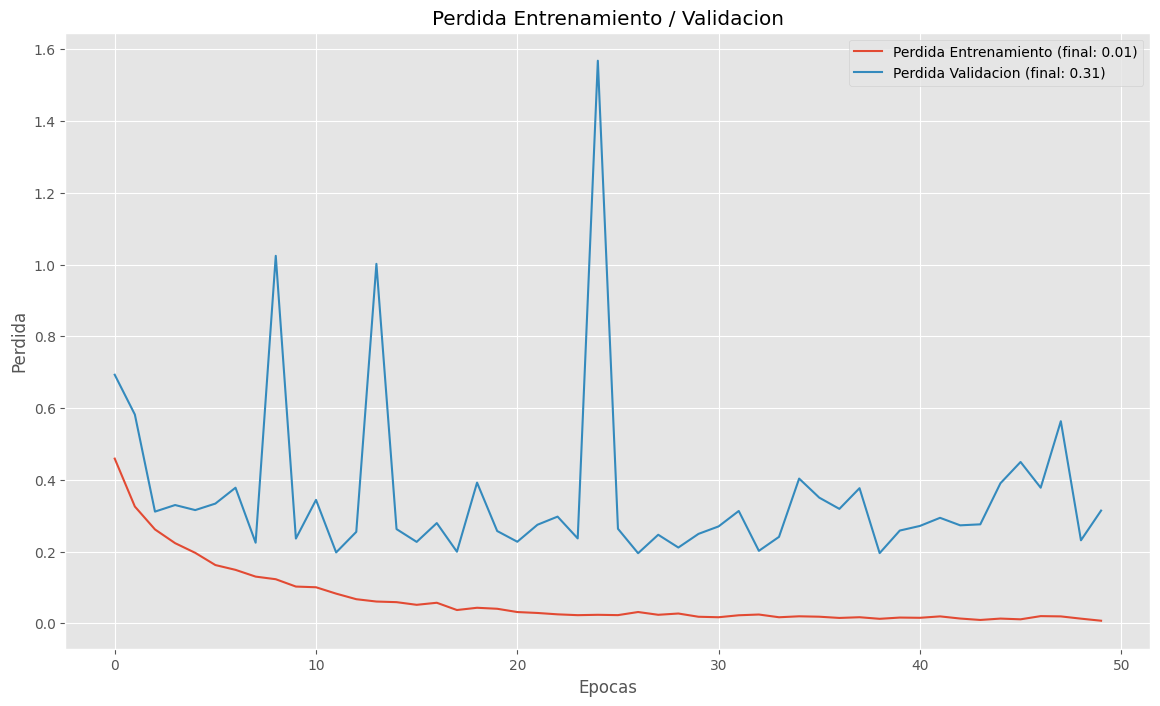

In [ ]:
grafica_loss(history_n)

---

**El loss de entrenamiento** muestra una disminucion constante a lo largo de las epocas, alcanzando un **valor final muy bajo de 0.01**. Esto indica que el modelo se ajusto muy bien a los datos de entrenamiento. *(o es el comenzamiento de un sobreajuste..)*

**El loss de validacion**, aunque mas alto que el de entrenamiento, tambien **muestra una tendencia a disminuir**, alcanzando un valor final de 0.31. Pero, **los diferentes picos que ocurren en la perdida de validacion dan a entender que puede haber cierta inestabilidad en la validacion.**

---

    Sensibilidad y especificidad en entrenamiento y validacion en funcion de las epocas:

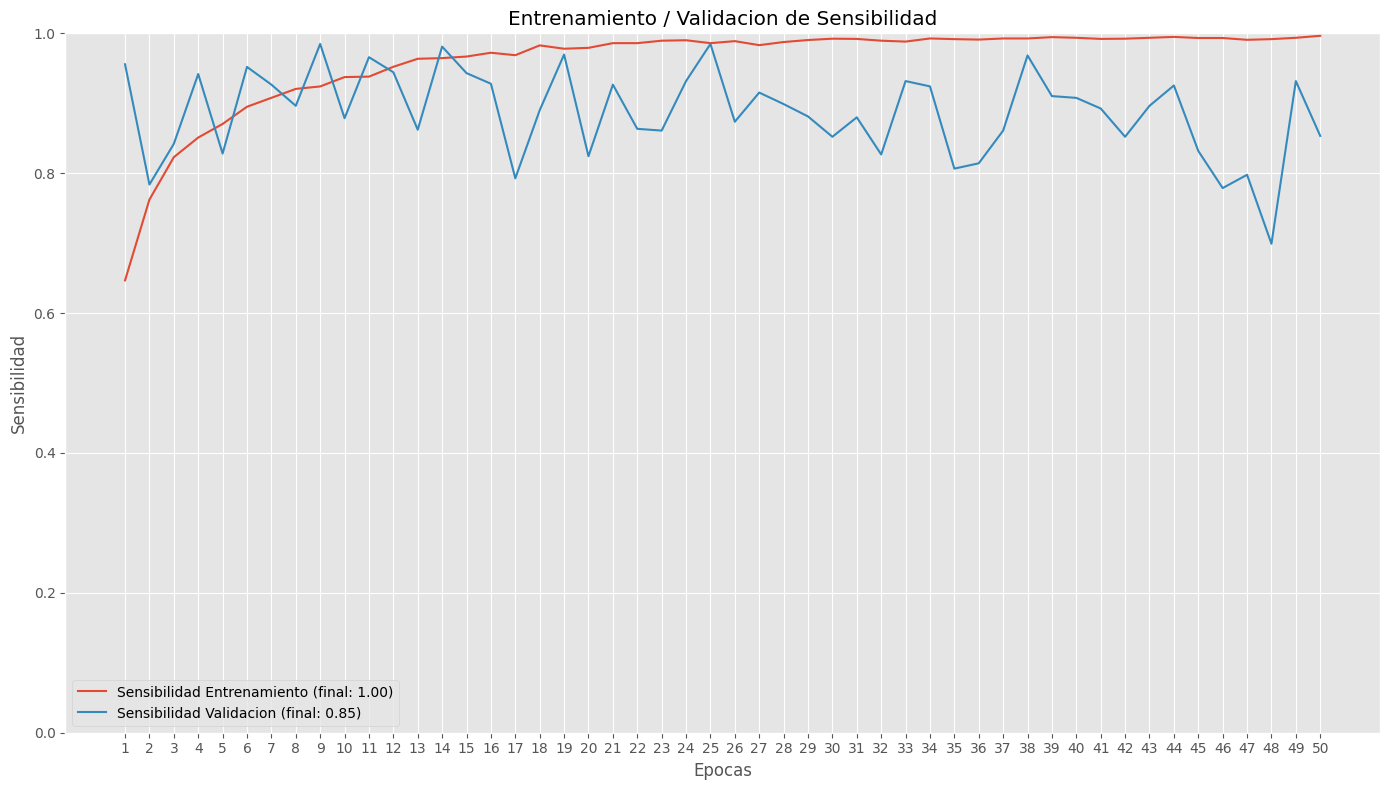

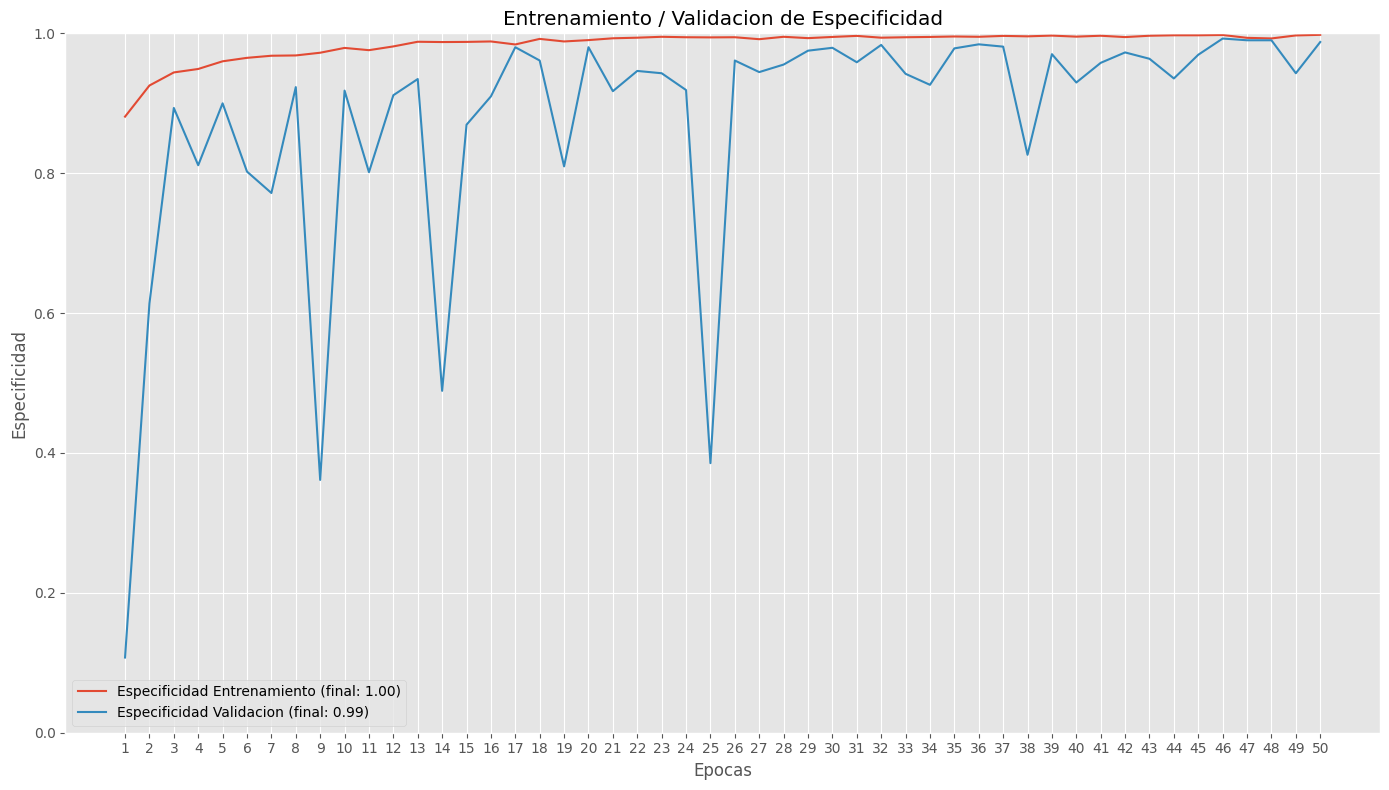

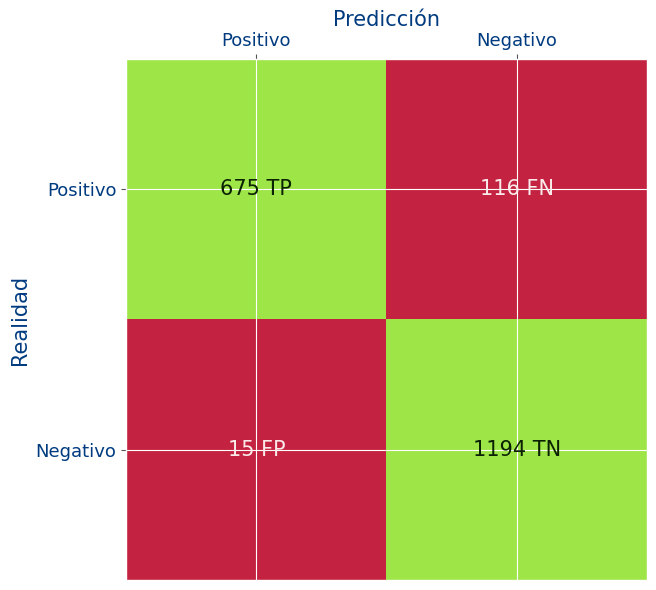

In [ ]:
grafica_sensitivity_specificity(history_n, model_n, validation_dataset)

---

**La sensibilidad en el entrenamiento** se pone alta y constante desde el principio, alcanzando el 100% desde las primeras epocas.

**La sensibilidad en la validacion**, aunque bastante alta (85%), muestra una variabilidad significativa. Esto sugiere que **el modelo es eficaz para detectar verdaderos positivos en los datos de entrenamiento, pero tiene dificultades para mantener esta eficacia en los datos de validacion.**

**La especificidad en el entrenamiento se mantiene alta y constante** igual que en la sensibilidad.


**La especificidad en la validacion**, aunque alta (99%), muestra una mayor variabilidad y algunos picos bastante significativos, pero a lo largo de las epocas estos van disminuyendo.

**La matriz de confusion** **muestra un buen balance** entre verdaderos positivos (675) y verdaderos negativos (1194), con relativamente pocos falsos positivos (15) y falsos negativos (116). Esto indica que el modelo tiene una buena capacidad de prediccion.

---

    Sensibilidad y especificidad segun el umbral:

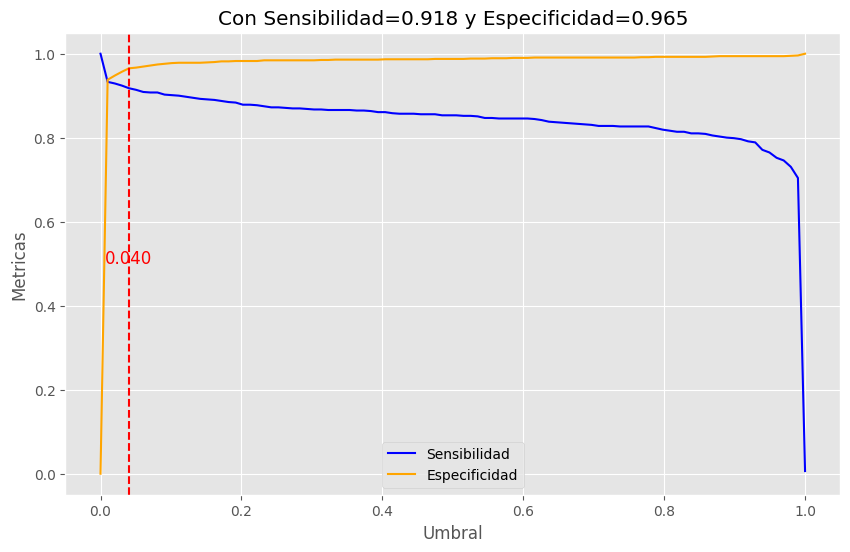

In [ ]:
generate_sens_spec_graph(model_n, validation_dataset)

---

**Esta grafica presenta un resultado sospechoso/raro**. La sensibilidad alcanza un pico inicial muy alto (0.918) y la especificidad es igualmente alta (0.965) y con un umbral **MUY** raro de (0.04).


Pero, la caida tan brusca en la sensibilidad al mover el umbral sugiere una anomalia o un problema bastante 'serio' en el entrenamiento.

---

**En general, el modelo muestra un rendimiento excelente en los datos de entrenamiento**, con una perdida muy baja, alta especificidad y sensibilidad. Pero, en los datos de validacion, aunque las metricas son buenas, **hay una variabilidad considerable en la especificidad y la sensibilidad**. Esto nos da a entender que **el modelo puede estar sobreajustado a los datos de entrenamiento y no generaliza tan bien a los datos no vistos.**

# **3. Modelo MobileNetV2**

## **3.1 Extraccion de caracteristicas**

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel_mobile.keras', monitor='val_sensitivity', mode='max', save_best_only=True, verbose=1)

In [ ]:
model_mn = modelo_mobilenet()
history_feature_extraction = model_mn.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint])

Epoch 1/50
244/244 [==============================] - ETA: 0s - loss: 0.5094 - sensitivity: 0.7262 - tp: 2276.0000 - tn: 3605.0000 - fp: 1046.0000 - fn: 858.0000
Epoch 1: val_sensitivity improved from -inf to 0.81542, saving model to bestmodel_mobile.keras
244/244 [==============================] - 19s 56ms/step - loss: 0.5094 - sensitivity: 0.7262 - tp: 2276.0000 - tn: 3605.0000 - fp: 1046.0000 - fn: 858.0000 - val_loss: 0.4674 - val_sensitivity: 0.8154 - val_tp: 645.0000 - val_tn: 941.0000 - val_fp: 268.0000 - val_fn: 146.0000
Epoch 2/50
242/244 [============================>.] - ETA: 0s - loss: 0.3906 - sensitivity: 0.7556 - tp: 2356.0000 - tn: 4014.0000 - fp: 612.0000 - fn: 762.0000
Epoch 2: val_sensitivity did not improve from 0.81542
244/244 [==============================] - 12s 48ms/step - loss: 0.3908 - sensitivity: 0.7562 - tp: 2370.0000 - tn: 4037.0000 - fp: 614.0000 - fn: 764.0000 - val_loss: 0.4008 - val_sensitivity: 0.7472 - val_tp: 591.0000 - val_tn: 1052.0000 - val_fp: 

## **3.2 Ajuste fino**

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sensitivity', patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel_mobile_ajustefino.keras', monitor='val_sensitivity', mode='max', save_best_only=True, verbose=1)

In [ ]:
# Descongelar las capas superiores del modelo base para el ajuste fino
base_model.trainable = True

# # Congelar todas las capas anteriores
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# Compilar nuevamente el modelo para el ajuste fino
model_mn.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(name='sensitivity'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.FalseNegatives(name='fn')])

history_fine_tuning = model_mn.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint])

Epoch 1/50
244/244 [==============================] - ETA: 0s - loss: 0.7580 - sensitivity: 0.7080 - tp: 2219.0000 - tn: 3920.0000 - fp: 731.0000 - fn: 915.0000
Epoch 1: val_sensitivity improved from -inf to 0.93805, saving model to bestmodel_mobile_ajustefino.keras
244/244 [==============================] - 50s 93ms/step - loss: 0.7580 - sensitivity: 0.7080 - tp: 2219.0000 - tn: 3920.0000 - fp: 731.0000 - fn: 915.0000 - val_loss: 2.4715 - val_sensitivity: 0.9381 - val_tp: 742.0000 - val_tn: 443.0000 - val_fp: 766.0000 - val_fn: 49.0000
Epoch 2/50
243/244 [============================>.] - ETA: 0s - loss: 0.4467 - sensitivity: 0.8128 - tp: 2545.0000 - tn: 4153.0000 - fp: 492.0000 - fn: 586.0000
Epoch 2: val_sensitivity did not improve from 0.93805
244/244 [==============================] - 20s 79ms/step - loss: 0.4466 - sensitivity: 0.8130 - tp: 2548.0000 - tn: 4158.0000 - fp: 493.0000 - fn: 586.0000 - val_loss: 1.2560 - val_sensitivity: 0.8824 - val_tp: 698.0000 - val_tn: 716.0000 - v

    Guardar modelo (por si acaso)

In [ ]:
tf.keras.saving.save_model(model_mn, '/content/drive/MyDrive/modelo_mobile_net.keras', overwrite=True)

In [ ]:
np.save("history_fine_tuning.npy",history_fine_tuning)

## **3.4 Realiza graficas**

    Perdida en entrenamiento y validacion en funcion de las epocas:

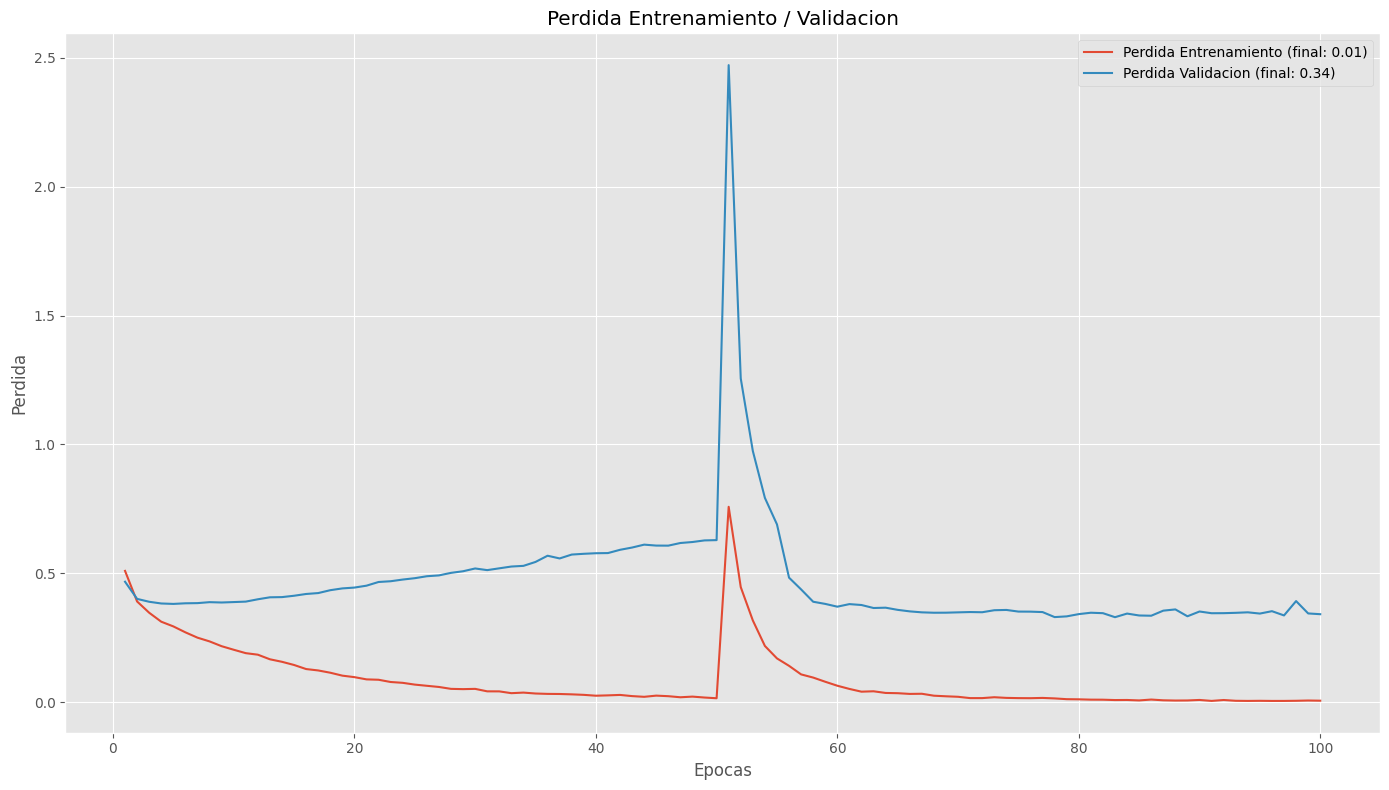

In [ ]:
grafica_loss_mobile(history_feature_extraction, history_fine_tuning)

---

**La perdida en el entrenamiento disminuye de manera constante, lo que indica que el modelo esta aprendiendo de manera correcta.**

---

    Sensibilidad y especificidad en entrenamiento y validacion en funcion de las epocas:


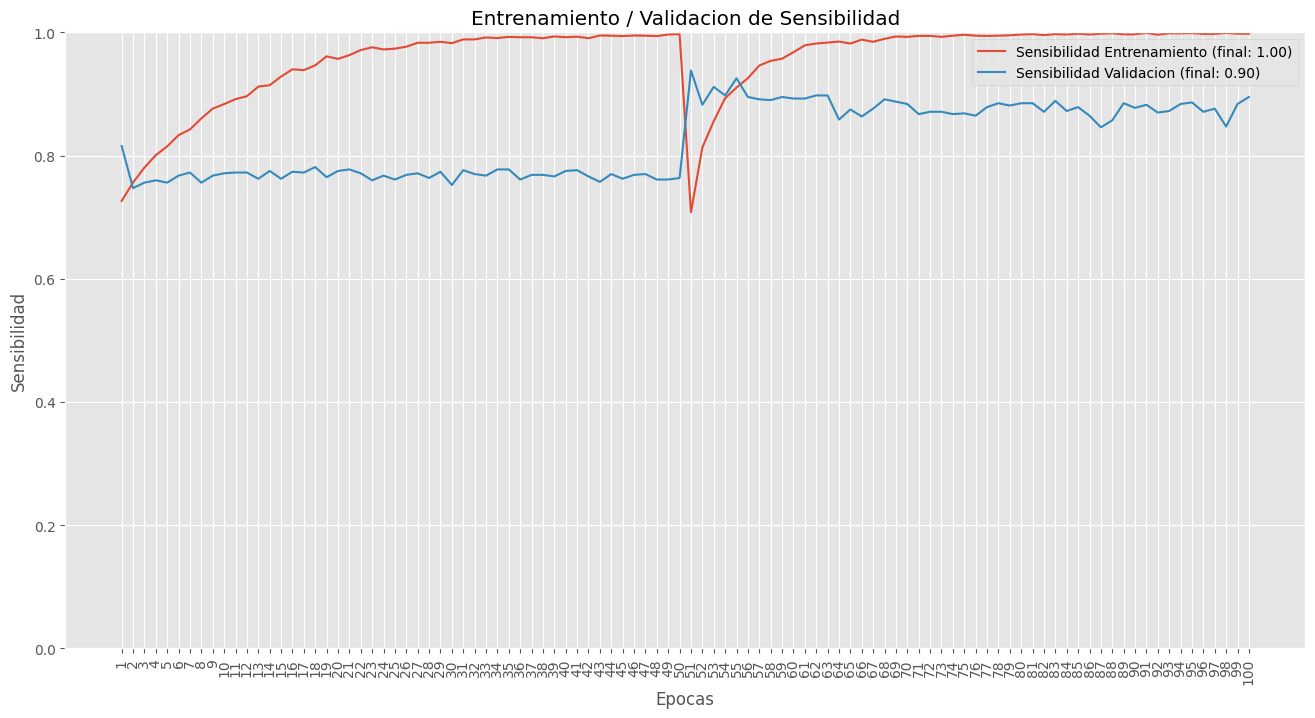

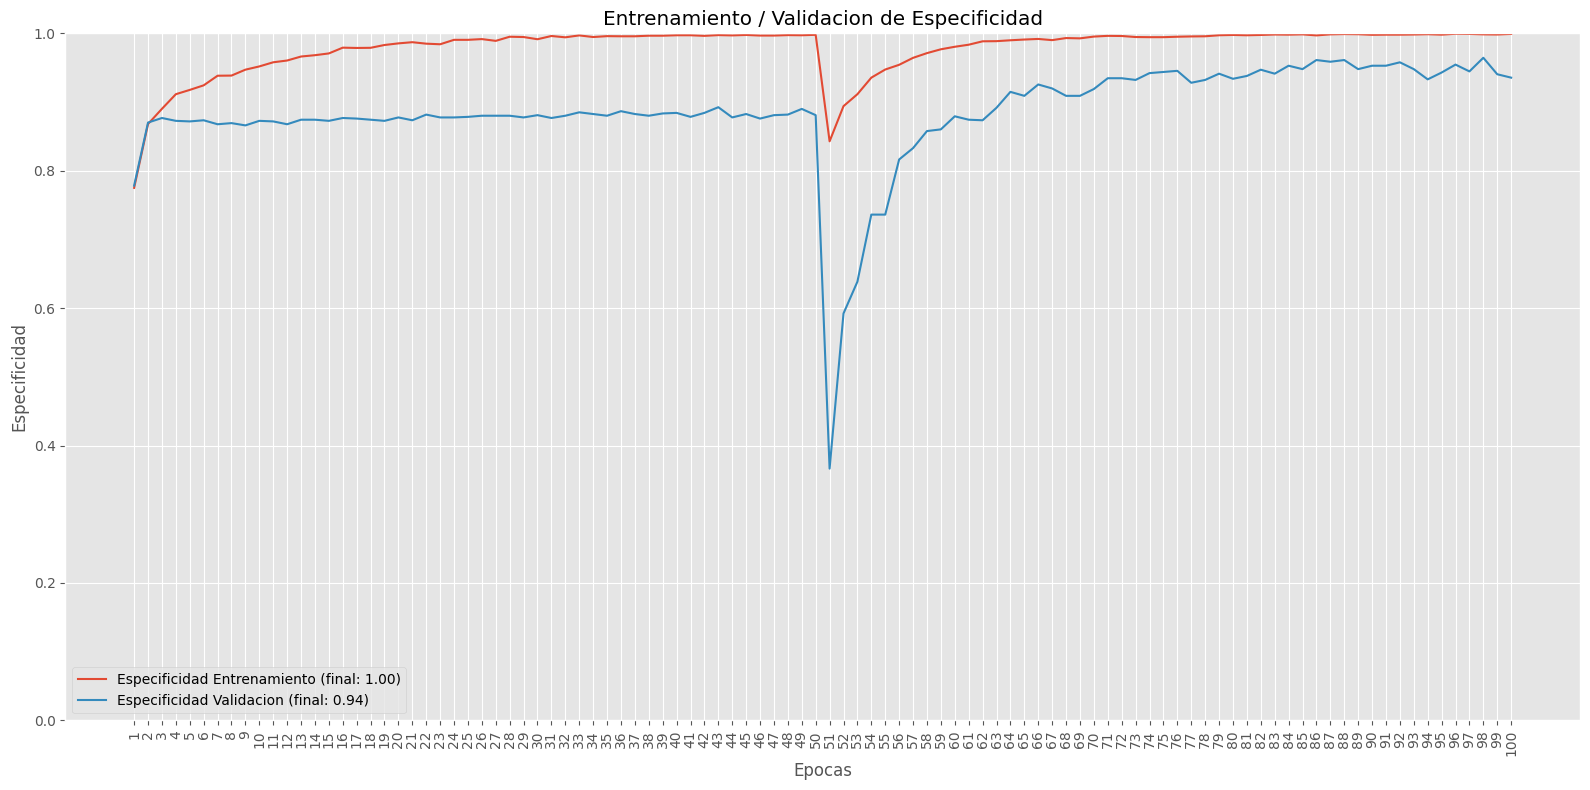

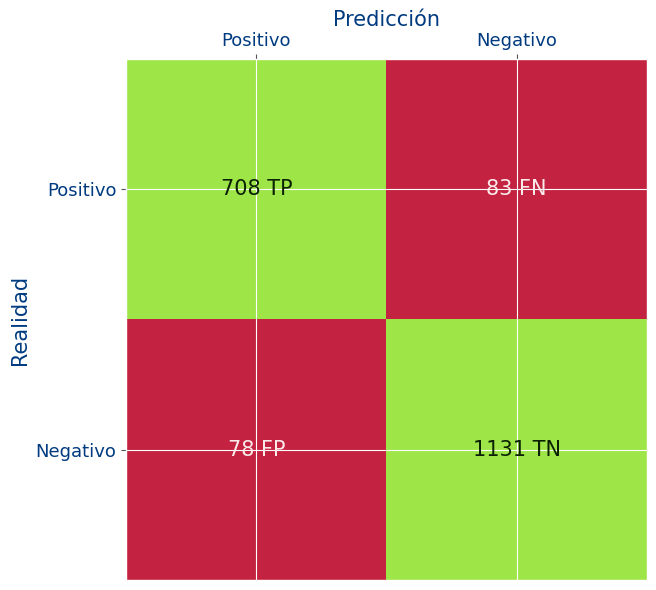

In [ ]:
grafica_sensitivity_specificity_mobile(history_feature_extraction, history_fine_tuning, model_mn, validation_dataset)

---

La **sensibilidad en entrenamiento llega** a 1, lo que sugiere que el modelo esta identificando bien a todos los menores de edad de manera correcta en los datos de entrenamiento. La **sensibilidad en validacion es menor** y mas variable, terminando en 0.90.

**La especificidad de entrenamiento se mantiene alta y estable**, cercana a 1, lo cual es excelente. Pero, la **especificidad en la validacion** tambien es alta pero muestra mas fluctuaciones, alcanzando un valor final de 0.94. Esto indica que el modelo es bueno para identificar de manera correcta a los mayores de edad.

**La matriz de confusion** tiene 708 TP, 1131 TN, 78 FP y 83 FN, lo que demuestra su alta especificidad y la buena sensibilidad, pero la presencia de falsos negativos sugiere que algunos menores de edad no fueron identificados de manera correcta.

---

    Sensibilidad y especificidad segun el umbral:

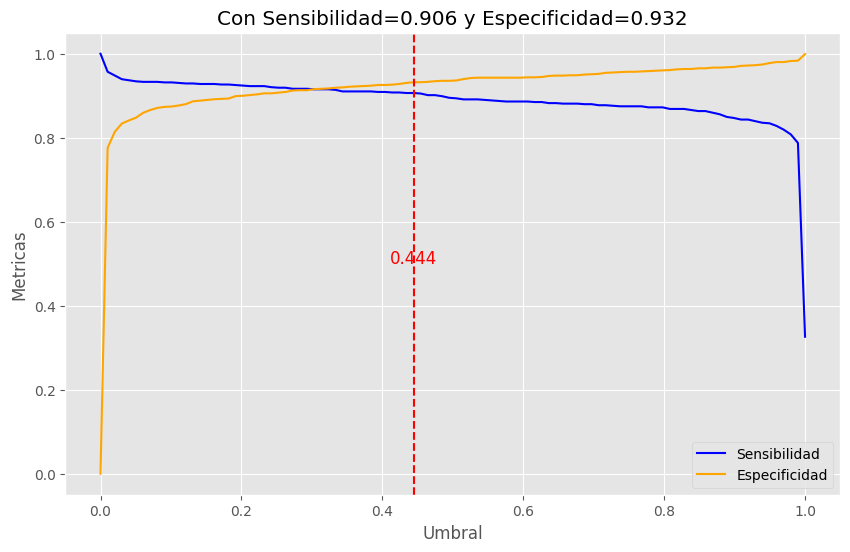

In [ ]:
generate_sens_spec_graph(model_mn, validation_dataset)


---

**El umbral optimo encontrado es 0.444**, con una sensibilidad de 0.906 y una especificidad de 0.932. Este umbral equilibra adecuadamente ambas metricas, aunque es importante notar que la sensibilidad es ligeramente inferior a la especificidad, lo cual podria ser critico para detectar menores de edad, para esto podriamos mover el umbral un poco

---

**El modelo MobileNetV2** muestra un buen rendimiento general con alta especificidad y una sensibilidad buena. **La alta especificidad es crucial para evitar falsos positivos, pero la sensibilidad es clave para asegurar que los menores de edad sean correctamente identificados.** La variabilidad en las metricas de validacion sugiere que podria haber mas ajuste fino necesario o mas datos para mejorar la estabilidad del modelo.

---

# **Conclusion final**

**Ambos modelos muestran buenos rendimientos**, pero en la tarea que tenemos de detectar menores de edad, donde es crucial tener una alta sensibilidad para evitar no identificar a un menor, **el modelo nuestro parece ser una mejor opcion**. Tiene una mejor combinacion de sensibilidad y especificidad, y un menor numero de falsos positivos....

**PERO**

Despues de que hayamos elegido el modelo nuestro y lo hemos incorporado a nuestro servicio, nos dimos cuenta que sacaba uno resultados **MUY MALOS**, por lo que decidimos usar el modelo de MobileNetV2 como nuestro modelo final, y ha tenido un rendimeinto bastante mejor que el primer modelo que hemos elegido.